In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, f1_score, cohen_kappa_score, roc_auc_score
from sklearn.preprocessing import normalize, label_binarize, LabelEncoder
#import xgboost as xgb
from sklearn import svm
from collections import defaultdict
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

%matplotlib inline

In [2]:
lfc_mb_filt=pd.read_csv('/Users/amandaspencer/Documents/mtb_tn_db/data/standardized_data/cleaned_ML/lfc_mb_filt_07_22_24.csv')
lfc_bin_mb_filt=pd.read_csv('/Users/amandaspencer/Documents/mtb_tn_db/data/standardized_data/cleaned_ML/bin_mb_filt.csv')

In [3]:
value_cols = [col for col in lfc_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']]
value_cols_lfc_bin = [col for col in lfc_bin_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']]

In [4]:
def rf_lr(mat, cols, C_lr):
    X=mat[cols].values
    y=mat['Functional_Category'].values
    n_classes=mat['Functional_Category'].nunique()
    preds_lr=np.zeros((len(y), n_classes))
    preds_rf=np.zeros((len(y), n_classes))
    #print(X,y)
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, y_train=SMOTE().fit_resample(X_train, y_train)
        lr=LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C_lr, random_state=42)
        rf=RandomForestClassifier(n_estimators=100)
        lr.fit(X_train,y_train)
        rf.fit(X_train, y_train)
        preds_lr[test_index,:]=lr.predict_proba(X_test)
        preds_rf[test_index,:]=rf.predict_proba(X_test)
    preds_rf_lr=np.concatenate((preds_lr,preds_rf), axis=1)
    print (preds_rf_lr.shape)
    return preds_rf_lr, y

In [5]:
def ensemble_lr(X, y, C, name):
    n_classes=len(np.unique(y))
    confusion=np.zeros((n_classes, n_classes))
    skf=StratifiedKFold(n_splits=2, shuffle=True)
    train_index, test_index=list(skf.split(X,y))[0]
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train, y_train=SMOTE().fit_resample(X_train, y_train)
    lr=LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C)
    lr.fit(X_train,y_train)
    y_hat=lr.predict(X_test)
    confusion+=confusion_matrix(y_test, y_hat)
    print (classification_report(y_test, y_hat))
    confusion=normalize(confusion, axis=1, norm='l1')
    accuracy=accuracy_score(y_test, y_hat)
    print (accuracy)
    col_names=['PE/PPE', 'cell wall and\ncell processes', 'information pathways', 'insertion seqs\nand phages', 'intermediary metabolism\nand respiration', 'lipid metabolism', 'regulatory proteins', 'virulence, detoxification,\nadaptation']
    confusion=confusion=pd.DataFrame(confusion, columns=col_names, index=col_names)
    #confusion=pd.DataFrame(confusion, columns=clf.classes_, index=clf.classes_)
    plt.figure(figsize=(7,7))
    rc={'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 14}
    sns.set(rc=rc)
    heat=sns.heatmap(confusion, annot=True, linewidths=.1, fmt='1.2f', square=True)
    heat.set(xlabel='PREDICTED CLASS', ylabel='TRUE CLASS', title=name)
    fig = heat.get_figure()
    fig.savefig('ensemble_preds.png', dpi=500, bbox_inches = "tight")
    return None

In [6]:
from tqdm import tqdm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np

def ensemble_multilabel(mat, cols, C_lr, norm_method, name, threshold=0.5, n_splits=3, figsize=(7, 7)):
    X = mat[cols].values
    y = mat['Functional_Category'].values
    n_classes = mat['Functional_Category'].nunique()
    accuracy = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    mlb = MultiLabelBinarizer()
    y_multi = mlb.fit_transform([[label] for label in y])
    
    y_true_all = []
    y_pred_all = []
    y_score_all = np.zeros((len(y), n_classes))
    y_score_all = []
    
    with tqdm(total=n_splits, desc="Cross-validation") as pbar:
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y_multi[train_index], y_multi[test_index]
            
            if norm_method == 'SMOTE':
                X_train, y_train = SMOTE().fit_resample(X_train, y_train)
            
            lr = LogisticRegression(penalty='l1', solver='liblinear', C=C_lr, random_state=42)
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            
            clf_lr = OneVsRestClassifier(lr)
            clf_rf = OneVsRestClassifier(rf)
            
            clf_lr.fit(X_train, y_train)
            clf_rf.fit(X_train, y_train)
            
            y_score_lr = clf_lr.predict_proba(X_test)
            y_score_rf = clf_rf.predict_proba(X_test)
            
            y_score_combined = (y_score_lr + y_score_rf) / 2
            y_hat_combined = (y_score_combined >= threshold).astype(int)
            
            y_true_all.extend(y_test)
            y_pred_all.extend(y_hat_combined)
            #y_score_all[test_index] = y_score_combined
            y_score_all.extend(y_score_combined)
            
            accuracy.append(accuracy_score(y_test, y_hat_combined))
            pbar.update(1)
    
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    y_score_all = np.array(y_score_all)
    
    # Per-class metrics
    col_names = ['PE/PPE', 'cell wall and\ncell processes', 'information pathways', 'insertion seqs\nand phages',
                 'intermediary metabolism\nand respiration', 'lipid metabolism', 'regulatory proteins', 'virulence, detoxification,\nadaptation']
    
    precisions = []
    recalls = []
    f1_scores = []
    roc_aucs = []
    
    print(f"\nPer-class metrics for {name}:")
    for i, class_name in enumerate(col_names):
        precision = precision_score(y_true_all[:, i], y_pred_all[:, i])
        recall = recall_score(y_true_all[:, i], y_pred_all[:, i])
        f1 = f1_score(y_true_all[:, i], y_pred_all[:, i])
        roc_auc = roc_auc_score(y_true_all[:, i], y_score_all[:, i])
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        roc_aucs.append(roc_auc)
        
        print(f"\nClass {i} - {class_name}:")
        print(f"  Precision: {precision:.3f}")
        print(f"  Recall: {recall:.3f}")
        print(f"  F1-score: {f1:.3f}")
        print(f"  ROC AUC: {roc_auc:.3f}")
    
    # Global metrics (macro average)
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1_scores)
    macro_roc_auc = np.mean(roc_aucs)
    
    print(f"\nGlobal Metrics (Macro Average) for {name}:")
    print(f"  Precision: {macro_precision:.3f}")
    print(f"  Recall: {macro_recall:.3f}")
    print(f"  F1-score: {macro_f1:.3f}")
    print(f"  ROC AUC: {macro_roc_auc:.3f}")
    
    # Plot ROC curves
    plt.figure(figsize=(12, 10))
    for i, class_name in enumerate(col_names):
        fpr, tpr, _ = roc_curve(y_true_all[:, i], y_score_all[:, i])
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_aucs[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc="lower right", fontsize='large')
    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()
    
    return None


Cross-validation: 100%|███████████████████████████| 5/5 [08:16<00:00, 99.39s/it]



Per-class metrics for Accuracy_log2FC_Ensemble_Multilabel_SMOTE_5fold:

Class 0 - PE/PPE:
  Precision: 0.362
  Recall: 0.315
  F1-score: 0.337
  ROC AUC: 0.836

Class 1 - cell wall and
cell processes:
  Precision: 0.476
  Recall: 0.065
  F1-score: 0.114
  ROC AUC: 0.586

Class 2 - information pathways:
  Precision: 0.244
  Recall: 0.087
  F1-score: 0.128
  ROC AUC: 0.691

Class 3 - insertion seqs
and phages:
  Precision: 0.379
  Recall: 0.408
  F1-score: 0.393
  ROC AUC: 0.839

Class 4 - intermediary metabolism
and respiration:
  Precision: 0.607
  Recall: 0.070
  F1-score: 0.125
  ROC AUC: 0.587

Class 5 - lipid metabolism:
  Precision: 0.349
  Recall: 0.081
  F1-score: 0.132
  ROC AUC: 0.586

Class 6 - regulatory proteins:
  Precision: 0.136
  Recall: 0.061
  F1-score: 0.084
  ROC AUC: 0.632

Class 7 - virulence, detoxification,
adaptation:
  Precision: 0.172
  Recall: 0.073
  F1-score: 0.102
  ROC AUC: 0.668

Global Metrics (Macro Average) for Accuracy_log2FC_Ensemble_Multilabel_SM

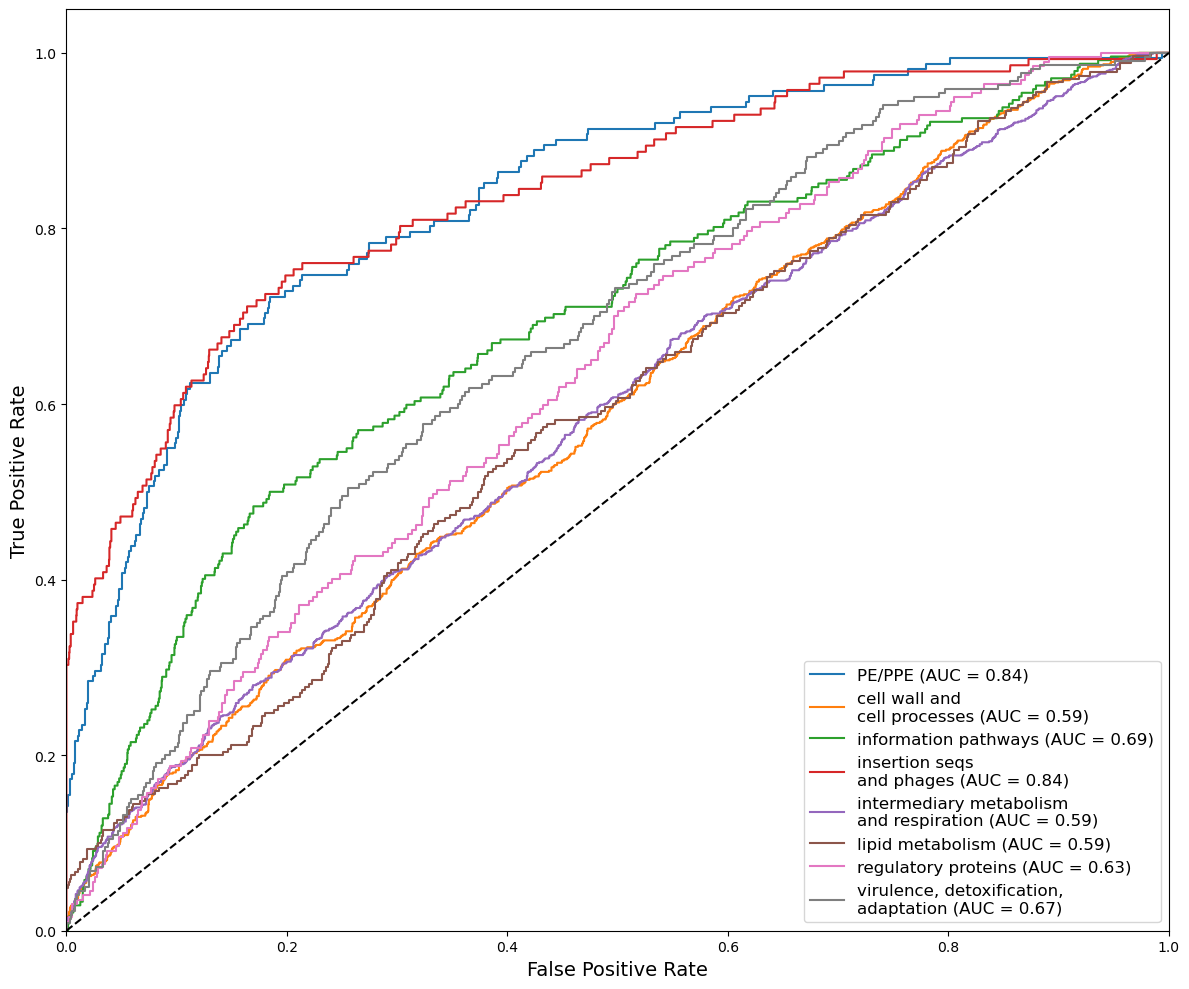

In [7]:
# Ensure the DataFrame and columns are correctly loaded
lfc_mb_filt = pd.read_csv('/Users/amandaspencer/Documents/mtb_tn_db/data/standardized_data/cleaned_ML/lfc_mb_filt_07_22_24.csv')
value_cols = [col for col in lfc_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']]

# Test with 5-fold cross-validation)
ensemble_multilabel(lfc_mb_filt, value_cols, C_lr=10, norm_method='SMOTE', name='Accuracy_log2FC_Ensemble_Multilabel_SMOTE_5fold', n_splits=5)


In [ ]:
X_ensemble,y_ensemble=rf_lr(lfc_bin_mb_filt, value_cols_lfc_bin, C_lr=10)

In [ ]:
X_ensemble[0,:]

In [ ]:
ensemble_lr(X_ensemble, y_ensemble, C=10, name='Accuracy_log2FC_bin_ensemble_SMOTE')

In [ ]:
#without title
ensemble_lr(X_ensemble, y_ensemble, C=10, name='')